# HARK and the Sequence Space Jacobian (SSJ) Method

By William Du (wdu9@jhu.edu) 

- This notebook demonstrates how HARK and the SSJ toolkit can be combined to solve a HANK model with fiscal policy. 
- Content here builds on the excellent foundation of this [SSJ notebook](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%201%20Fiscal%20Policy.ipynb) 

## HARK Solves for the Microeconomic Steady State

Essentially all structural micro models are Bellman problems

HARK is designed to solve difficult micro Bellman problems with
- uncertainty
- nondifferentiable constraints (e.g., liquidity)
- discontinuities
- and other challenging features

HARK has a library of reproducible solved models:
- Lifecycle models
- Discrete-continuous choice
    - e.g. retirement and consumption
    - lumpy durable goods purchases
- Portfolio choice
    - between risky and safe, liquid and illiquid
- Labor supply decisions 
- And particularly problems where agents have several choices:
    - e.g., consumption and portfolio choice
</br>

## SSJ toolkit takes micro soln as input, and calculates macro

- SSJ was created to solve HANK models
    - given the solution to the steady state of a micro model

- Its big insight: Solving the microeconomic model (in steady state) can be *independent* of working out macroeconomic dynamics

## HARK $\rightarrow$ SSJ lets us solve macro models with rich micro realism

# Model

We illustrate here using a HANK model from the [lecture slides](https://github.com/shade-econ/nber-workshop-2022/blob/main/Lectures/Lecture%204%20Fiscal%20Policy.pdf) from the SSJ authors' heterogeneous agent workshop.

## Model features

- Households:
    - Have access to a riskfree asset for saving/borrowing
    - Face realistically calibrated idiosyncratic income shocks

- Macro:
    - Sticky wages
    - Government budget constraint:
        - Expenditures: Unemployment insurance system
        - Taxes: labor income
        - Fiscal rule: Debt to GDP ratio


## Bringing Model to Code

We first import
- some basic, commonly used numerical tools (e.g. numpy and scipy)
- the IndShockConsumerType from HARK
- the SSJ toolkit

In [1]:
# Basic scientific tools
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import optimize

# HARK agents
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType,
    IndShockConsumerType_constructors_default,
)
from HARK.Calibration.Income.IncomeProcesses import (
    construct_HANK_lognormal_income_process_unemployment,
)

# Sequence space Jacobian toolkit
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc

### Calibrate Steady State Values

Next, we calibrate the steady state values of some outcomes, and calculate a few values implied by them.

In [2]:
# Steady state calibration
r_ss = 0.03  # Interest rate
G_ss = 0.2  # Government spending
B_ss = 0.2  # Government debt (bonds)
Y_ss = 1.0  # Output

# steady state relations
T_ss = G_ss + r_ss * B_ss  # Lump sum taxes to keep debt constant
Z_ss = Y_ss - T_ss  # After tax labor income
F_ss = G_ss - T_ss  # Government budget deficit

### Micro Agent Parameters

Microeconomic agents in HARK have a rich set of parameters wired into them by default.

We need only specify the parameters whose values we want to highlight

In [3]:
# Swap out the default income process for one with a couple more parameters
HANK_constructors = IndShockConsumerType_constructors_default.copy()
HANK_constructors["IncShkDstn"] = construct_HANK_lognormal_income_process_unemployment

HANK_dict = {
    "Rfree": [1.0 + r_ss],  # Interest factor on assets
    "tax_rate": [0.0],  # Assume that labor here is actually after tax income
    "labor": [Z_ss],  # Will be solving the micro model in steady state
    "wage": [1.0],  # Default value
    "UnempPrb": 0.0,  # Probability of unemployment while working
    "IncUnemp": 0.0,  # Unemployment benefits replacement rate
    "LivPrb": [0.98],  # Turn off mortality so that resources don't vanish
    "aXtraMax": 50.0,  # Higher than usual top of assets grid
    "aXtraCount": 100,  # And more points in the grid
    "constructors": HANK_constructors,  # Put the replacement constructor into the parameter dictionary
    "cycles": 0,  # specify that it's an infinite horizon problem
}

# Specify parameters for assets (or capital) and consumption grids
assets_grid_spec = {
    "min": 0.0,
    "max": 50.0,
    "N": 501,
}
cons_grid_spec = {
    "min": 0.0,
    "max": 5.0,
    "N": 151,
}
my_grid_specs = {
    "kNrm": assets_grid_spec,
    "cNrm": cons_grid_spec,
}

## Find Equilibrium Discount Factor

Above, we exogenously calibrated the steady state level of government debt $B_{ss}$. $B_{ss}$ should be *owned* by someone, so in equilibrium our agents must want to hold the same level of assets as there are government bonds. To accomplish this, we specify a function that yields steady state asset holdings as a function of agents' discount factor $\beta$, and another function that simply differences it with our target level of assets. The appropriate discount factor can then be found by performing a bounded search for a root of the difference function.

In [4]:
# Define function to compute steady-state aggregate assets as a function of the discount factor
def calc_SS_assets_from_discfac(beta):
    temp_dict = HANK_dict.copy()
    temp_dict["DiscFac"] = beta  # set the proposed discount factor
    TempAgent = IndShockConsumerType(**temp_dict)  # make an AgentType instance

    # Compute and return steady state assets
    TempAgent.solve()
    TempAgent.initialize_sym()
    X = TempAgent._simulator  # for shorter typing
    X.make_transition_matrices(my_grid_specs, norm="PermShk")
    X.find_steady_state()
    A_dstn = np.dot(X.steady_state_dstn, X.outcome_arrays[0]["aNrm"])
    A_ss = np.dot(A_dstn, X.outcome_grids[0]["aNrm"])
    return A_ss


# the "gap" is the distance between target assets and actual
def calc_asset_gap(beta):
    return calc_SS_assets_from_discfac(beta) - A_target

In [5]:
# Discount factor takes value that generates the (calibrated) $B$
A_target = B_ss
DiscFac_star = optimize.brentq(calc_asset_gap, 0.85, 0.99)
print("Found discount factor of {:.5f}".format(DiscFac_star))

Found discount factor of 0.97975


## Make Agents with Calibrated Discount Factor

Now that we have $\beta^{*}$, we can make an AgentType instance that will be used for the general equilibrium analysis. We make an instance of the `NewKeynesianConsumerType` whose discount factor is $\beta^{*}$. 

To verify that we did what we set out to do, we can check that the output goods market clears (output is accounted for by consumption and government spending) and that the asset market clears (retained assets are accounted for by government bonds). Both conditions should be very close to zero.

In [6]:
# Create a HARK agent
HANK_dict["DiscFac"] = DiscFac_star
Agent_GE = IndShockConsumerType(**HANK_dict)

# Calculate steady state assets and consumption
Agent_GE.solve()
Agent_GE.initialize_sym()
X = Agent_GE._simulator  # for shorter typing
X.make_transition_matrices(my_grid_specs, norm="PermShk")
X.find_steady_state()
A_dstn = np.dot(X.steady_state_dstn, X.outcome_arrays[0]["aNrm"])
A_ss = np.dot(A_dstn, X.outcome_grids[0]["aNrm"])
C_dstn = np.dot(X.steady_state_dstn, X.outcome_arrays[0]["cNrm"])
C_ss = np.dot(C_dstn, X.outcome_grids[0]["cNrm"])

# Verify market clearing conditions
print("Goods clearing condition:", Y_ss - C_ss - G_ss)
print("Asset clearing condition:", A_ss - B_ss)

Goods clearing condition: 0.0061186865636854715
Asset clearing condition: -1.7947032748821812e-12


## Compute Sequence Space Jacobian Matrices

A deep insight that has recently made a major impact on our ability to handle heterogeneous agents models with serious microeconomic heterogeneity is that, even when the microeconomic problems agents face are deeply nonlinear (in ways that are fundamentally important to their sense-making), deviations from the steady state of a macroeconomy populated by such agents tend to be very close to linear.  That is, the macroeconomy can be linearized.  

In large part this is because the measured magnitude of aggregate shocks is tiny compared to the degree of microeconomic heterogeneity.  Aggregate permanent income shocks, for example, are 100 times smaller than idiosyncratic shocks.

Linearization makes it appropriate to calculate the dynamics of the model with response to 'MIT shocks,' as opposed to needing to develop more complicated functions. In technical terms, this means that the crucial (and only) thing we need from the micro model is its response to small future disturbances-- the sequence space Jacobian (SSJ) matrices.

(We need to know the response to future shocks so that we can think coherently, for example, about monetary policy in which future movements in the Fed Funds rate are predictable, or where "forward guidance" is provided).

HARK has a tool for calculating the SSJ matrices that characterize consumption and asset responses to an exogenous *transitory* change in the interest factor (Rfree) or labor income (labor) that will occur in the future. This is accomplished with the `calc_jacobian` method, passing as arguments the name of the variable that will be changed and the maximum number of periods in the future that a (marginal) change could occur.

The outputs of this method are objects that represent the sensitivity of aggregate consumption and asset holdings (respectively) in each period to the *advance knowledge* of an exogenous change in each parameter.

In [7]:
# Time the computation of the Jacobian matrices
start = time.time()

# Jacobians of consumption and assets w.r.t. interest factor changes up to 300 periods ahead
dCdR, dAdR = Agent_GE.make_basic_SSJ(
    "Rfree", ["cNrm", "aNrm"], my_grid_specs, norm="PermShk", solved=True, offset=True
)

# Jacobians of consumption and assets w.r.t. labor supply changes up to 300 periods ahead
dCdZ, dAdZ = Agent_GE.make_basic_SSJ(
    "labor", ["cNrm", "aNrm"], my_grid_specs, norm="PermShk", solved=True, offset=True
)

stop = time.time()
print("Time to compute Jacobians: {:.3f} seconds.".format(stop - start))

Time to compute Jacobians: 19.086 seconds.


## Plot Sequence Space Jacobians

To inspect the SSJ  matrix for aggregate consumption, we can plot some of its rows/columns, representing the consumption response to a change in the interest factor or labor income $T$ periods in the future.

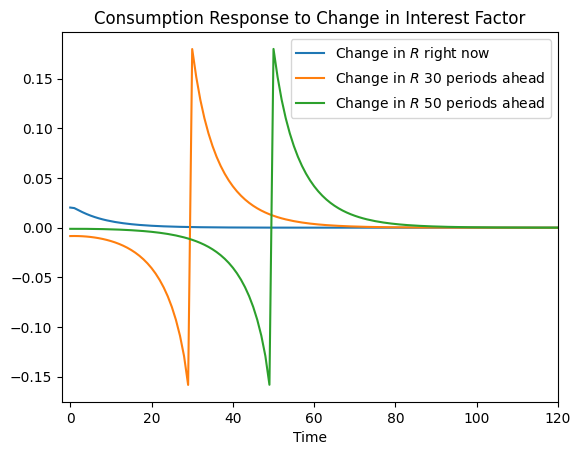

In [8]:
plt.plot(dCdR.T[0])
plt.plot(dCdR.T[30])
plt.plot(dCdR.T[50])
plt.legend(
    [
        r"Change in $R$ right now",
        r"Change in $R$ 30 periods ahead",
        r"Change in $R$ 50 periods ahead",
    ]
)
plt.xlim(-2, 120)
plt.title("Consumption Response to Change in Interest Factor")
plt.xlabel("Time")
# plt.yticks([])
plt.show()

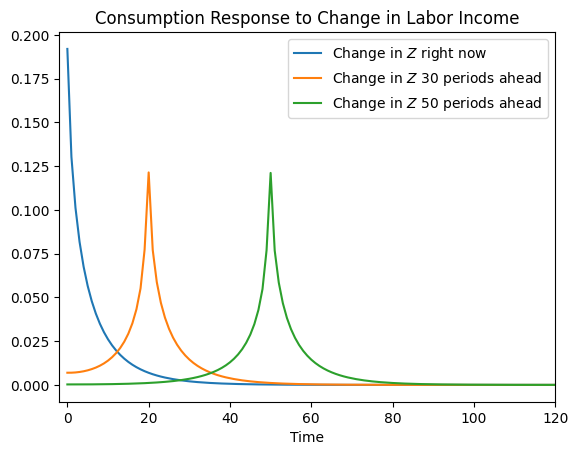

In [9]:
plt.plot(dCdZ.T[0])
plt.plot(dCdZ.T[20])
plt.plot(dCdZ.T[50])
plt.xlim(-2, 120)
plt.legend(
    [
        r"Change in $Z$ right now",
        r"Change in $Z$ 30 periods ahead",
        r"Change in $Z$ 50 periods ahead",
    ]
)
plt.xlim(-2, 120)
plt.title("Consumption Response to Change in Labor Income")
plt.xlabel("Time")
# plt.yticks([])
plt.show()

# Government Budget Constraint and Market Clearing

We now need to specify the other blocks of this fiscal HANK model. The details of the model found [here](https://github.com/shade-econ/nber-workshop-2022/blob/main/Lectures/Lecture%204%20Fiscal%20Policy.pdf) tell us that only the governemnt budget constraint and the market clearing conditions need to be specified explicitly to capture the dynamics of the HANK model.

The sequence space Jacobian toolkit allows us to specify other blocks of the economy in a DYNARE-esque fashion as we simply need to write down the difference equations that define our model.

In [10]:
# Government Budget Constraint
@sj.simple
def fiscal(B, r, G, Y):
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    return T, Z, deficit


# Market Clearing Conditions
@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B  # asset market clearing
    goods_mkt = Y - C - G  # goods market clearing
    return asset_mkt, goods_mkt

In [11]:
# Store Jacobians in JacobianDict Object.
# This will capture behavior of heterogeneous hosueholds.
het_household_block = JacobianDict({"C": {"Z": dCdZ}, "A": {"Z": dAdZ}})

In [12]:
# SteadyStateDict:
# - Steady state values of each variable; we perturb around this steady state.
SteadyState_dict = SteadyStateDict(
    {
        "asset_mkt": 0.0,
        "goods_mkt": 0.0,
        "deficit": G_ss - T_ss,
        "B": B_ss,  # Gov. Debt
        "r": r_ss,  # Interest rate
        "G": G_ss,  # Gov. Spending
        "Y": Y_ss,  # Output
        "A": B_ss,  # Assets
        "C": C_ss,  # Consumption
        "Z": Y_ss - T_ss,  # Income (post-tax)
        "T": T_ss,  # Lump Sum Taxes
    }
)

In [13]:
# Create the model by combining three blocks:
# (1) microeconomic responses to macroeconomic news (Jacobians)
# (2) fiscal authority behavior
# (3) market clearing conditions
HANK = sj.create_model([het_household_block, fiscal, mkt_clearing], name="HA Model")

In [14]:
# Choose aggregate shock parameters for the simulation
T = 300  # <-- the length of the impulse response function
rho_G = 0.8  # peristence of shock
dG = 0.01 * rho_G ** np.arange(T)
shocks = {"G": dG}

In [15]:
# Obtain impulse responses
unknowns_td = ["Y"]  # unknowns to solve for
targets_td = ["asset_mkt"]  # to clear target condition below

# Solve for impulse responses to gov. spending shock (balanced budget)
irfs_G_lin = HANK.solve_impulse_linear(
    SteadyState_dict, unknowns_td, targets_td, shocks
)

In [16]:
# Define a function that can plot impulse response functions
def show_irfs(
    irfs_list,
    variables,
    labels=[" "],
    ylabel=r"Percentage points (dev. from ss)",
    T_plot=50,
    figsize=(18, 6),
):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i == 0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

## Government Spending Shock (Balanced Budget)

The plot belows illustrate the impulse responses to a government spending shock that is completely funded by increases in taxes. 


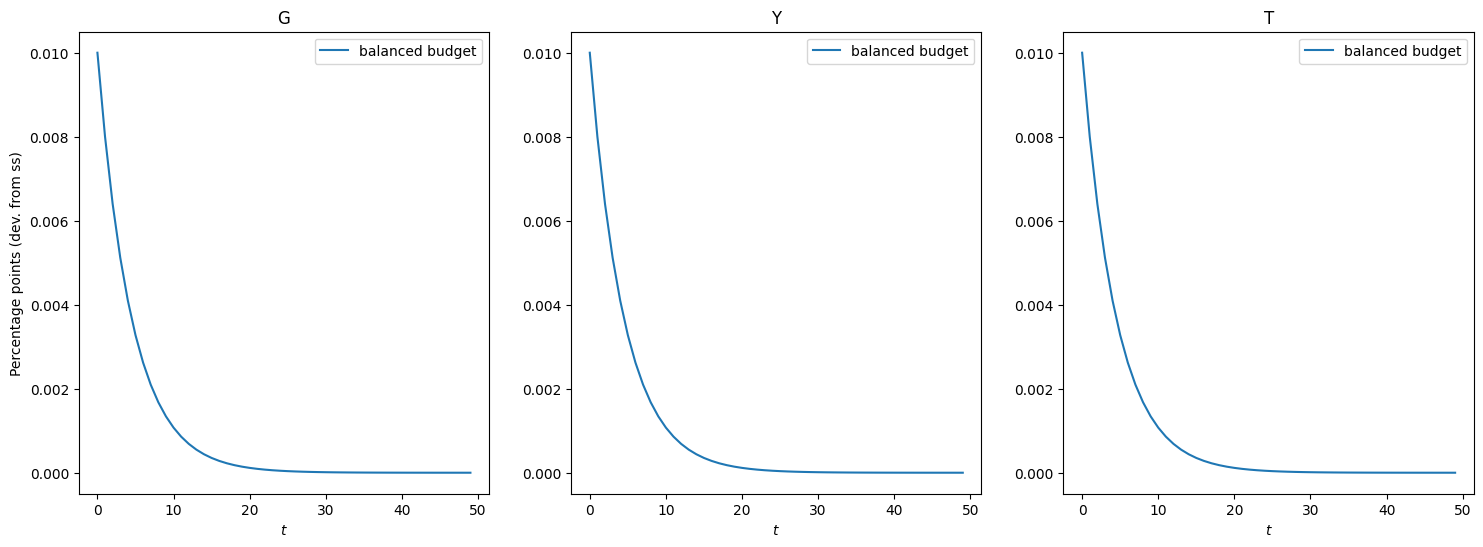

In [17]:
# Plot the Impulse Response Function
show_irfs([irfs_G_lin], ["G", "Y", "T"], labels=["balanced budget"])

## Government spending shock (deficit financed)

Now let us produce the responses to a government spending shock when it is mostly deficit financed. 

To do so, we will shock government debt such that the cumulative sum of debt shock is equal to the cumulative sum of the increase in government spending.

In [18]:
# Define a 'fiscal rule' to this government spending shock
# by specifying a shock to debt that will finance the gov. spending shock
rho_B = 0.9  # how fast to move back toward fiscal target
dB = np.cumsum(dG) * rho_B ** np.arange(T)

# Debt-financed government spending means we shock both government spending and debt
shocks_B = {"G": dG, "B": dB}

In [19]:
# Solve for impulse responses
irfs_B_lin = HANK.solve_impulse_linear(
    SteadyState_dict, unknowns_td, targets_td, shocks_B
)

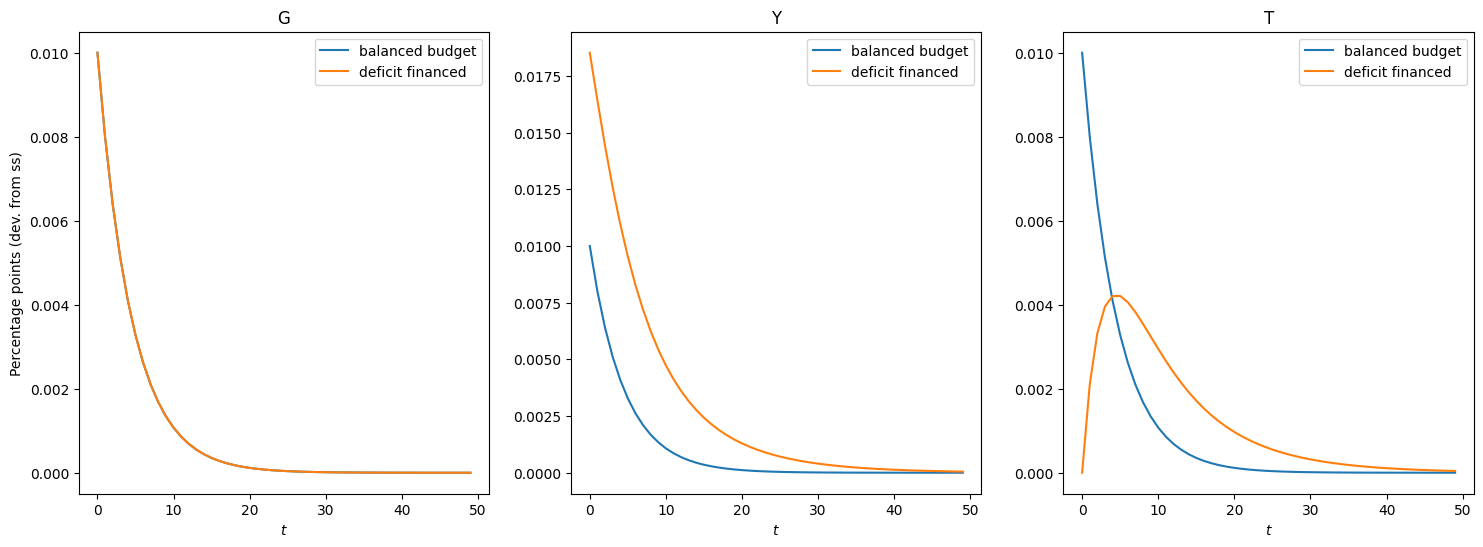

In [20]:
# Show government spending, output, and taxes
show_irfs(
    [irfs_G_lin, irfs_B_lin],
    ["G", "Y", "T"],
    labels=["balanced budget", "deficit financed"],
)

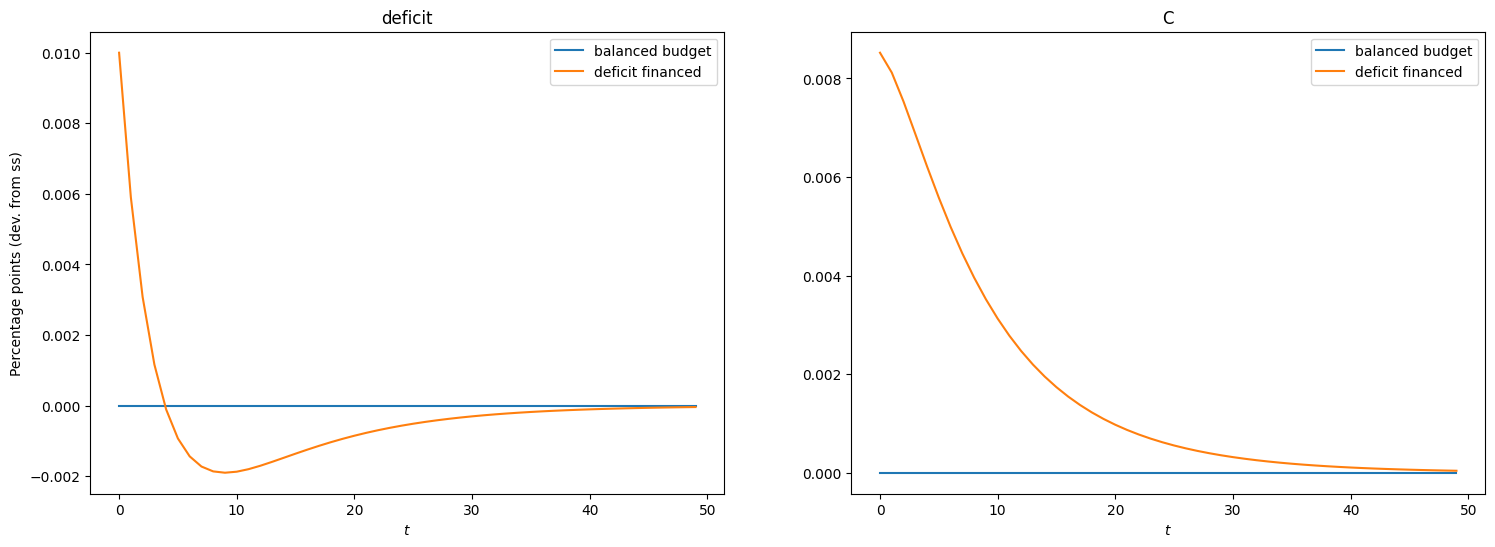

In [21]:
# Show the deficit and consumption
show_irfs(
    [irfs_G_lin, irfs_B_lin],
    ["deficit", "C"],
    labels=["balanced budget", "deficit financed"],
)

# Why does HANK matter?

Let us compare deficit financed government spending responses in HANK vs TANK vs RANK.

To do so, a representative agent and a two agent household block will be specified to produce a RANK and TANK model. 


## Specify a representative agent household

The representative agent household solution can be expressed analytically; below are the difference equations (Euler equation and budget constraint) that define the representative agent problem.

In [22]:
@sj.solved(
    unknowns={"C": 1, "A": 1}, targets=["euler", "budget_constraint"]
)  # solver="broyden_custom")
def hh_ra(C, A, Z, eis, beta, r):
    euler = (beta * (1 + r(+1))) ** (-eis) * C(+1) - C  # RA euler equation
    budget_constraint = (1 + r) * A(-1) + Z - C - A  # RA budget constraint
    MPC = 0
    return euler, budget_constraint, MPC


# create RANK model where heterogeneous household block hh_ha is replaced with RA block 'hh_ra'
RANK = sj.create_model([hh_ra, fiscal, mkt_clearing], name="Representative agent model")

## Specify a Two Agent (TA) economy (Campbell-Mankiw)

As in the rep. agent problem, the difference equations (euler equation and budget constraint) that define the two agent problem are analytically available.

In [23]:
# Deep in SSJ weeds, we need this object:
@sj.solved(
    unknowns={"C_RA": 1, "A": 1}, targets=["euler", "budget_constraint"]
)  # , solver="broyden_custom")

# household_twoagent:
def hh_ta(C_RA, A, Z, eis, beta, r, lam):
    # consumption of infinitely lived household
    euler = (beta * (1 + r(+1))) ** (-eis) * C_RA(+1) - C_RA
    # hand to mouth agent consumes income Z
    C_H2M = Z
    # aggregate C is weighted sum of C of two types
    C = (1 - lam) * C_RA + lam * C_H2M  # lam is frac of hand to mouth households
    # aggregate budget constraint
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    MPC = 0
    return euler, budget_constraint, C_H2M, C, MPC


# create TANK model where heterogeneous household is replaced with 'hh_ta'
TANK = sj.create_model([hh_ta, fiscal, mkt_clearing], name="Two agent model")

## Calibrate and find steady states of TANK and RANK models.

Now that we have defined the representative agent and two agent models, we need to solve for a steady state in each model for which we will perturb around later to solve for dynamics.

In [24]:
# base dictionary for calibrating representative agent and two agent household.
calibration = {
    "eis": 0.5,  # EIS
    "G": G_ss,  # Government spending
    "B": B_ss,  # Government debt
    "Y": Y_ss,  # Output
    "r": r_ss,
}  # Number of productivity grid points

In [25]:
# Rep Agent calibration
calibration_ra = calibration.copy()
calibration_ra["beta"] = 1 / (1 + calibration_ra["r"])  # for steady state consumption
calibration_ra["B"] = calibration["B"]

unknowns_ra_ss = {
    "C": 1.0,
    "A": 0.8,
}  # solve for two unknowns to clear the targets below
targets_ra_ss = {"budget_constraint": 0.0, "asset_mkt": 0.0}

# solve for steady state for RANK model
ss_RANK = RANK.solve_steady_state(
    calibration_ra, unknowns_ra_ss, targets_ra_ss, dissolve=["hh_ra"]
)  # solve steady state for RANK model

In [26]:
# Two Agent calibration
calibration_ta = calibration_ra.copy()  # dictionary for two agent block
calibration_ta["lam"] = 0.25  # proportion of hand to mouth
unknowns_ta_ss = {
    "C_RA": 1.0,
    "A": 0.8,
}  # solve for two unknowns to clear the targets below

# solve for steady state for TANK model
ss_TANK = TANK.solve_steady_state(
    calibration_ta, unknowns_ta_ss, targets_ra_ss, dissolve=["hh_ta"]
)  # solve steady state for TANK model

## Impulse responses to deficit financed G shocks:
### HANK vs TANK vs RANK

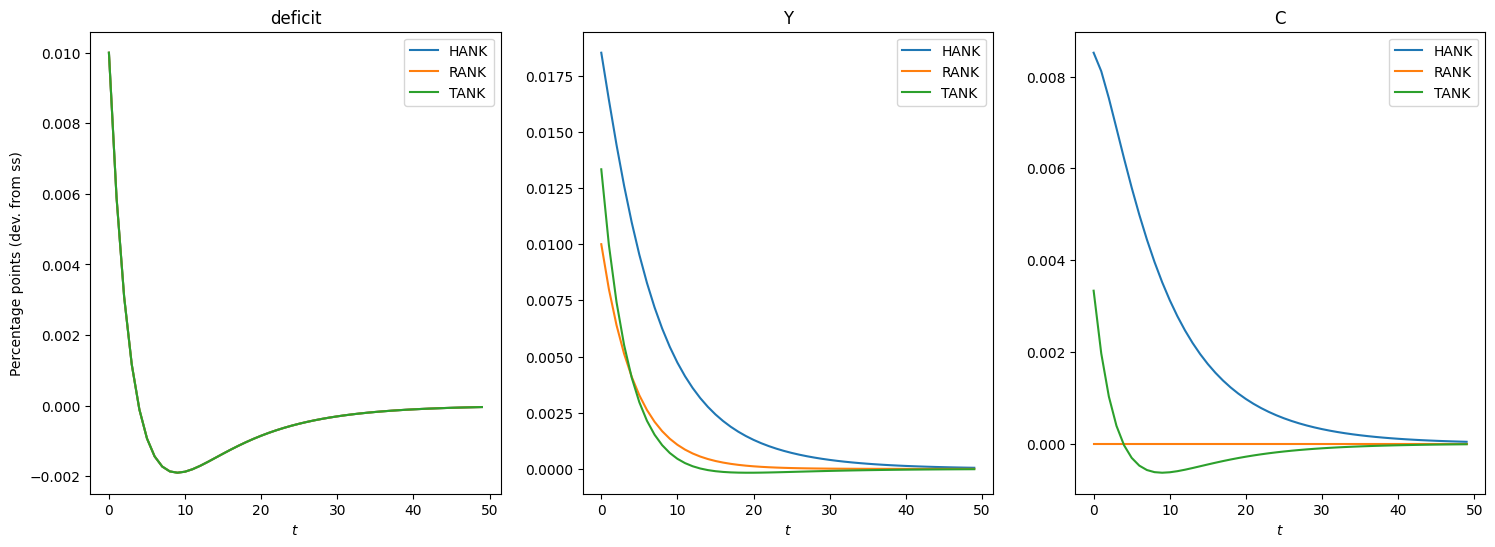

In [27]:
irfs_RANK = RANK.solve_impulse_linear(
    ss_RANK, unknowns_td, targets_td, shocks_B
)  # solve for impulse responses in RANK model
irfs_TANK = TANK.solve_impulse_linear(
    ss_TANK, unknowns_td, targets_td, shocks_B
)  # solve for impulse responses in TANK model

# Plot irfs of HANK, RANK, and TANK
show_irfs(
    [irfs_B_lin, irfs_RANK, irfs_TANK],
    variables=["deficit", "Y", "C"],
    labels=["HANK", "RANK", "TANK"],
)

# Simulating time series

## Simulate deficit financed government spending shocks.

In [28]:
from estimation.routines import simulate

outputs = ["Y", "C", "deficit", "G"]  # aggregate variables to be simulated

impulses_ha = {}
impulses_ra = {}
impulses_ta = {}

shk_std = 0.001  # standard deviation of shock
rho_G = 0.8  # persistence of G shock
rho_B = 0.9  # persistence of Deficit shock

dG = shk_std * 0.8 ** np.arange(T)  # G Shock series
dB = np.cumsum(dG) * rho_B ** np.arange(T)  # deficit shock series (fiscal rule)

# own_shock captures AR shock process to deficit financed G spending
own_shock = {"G": shk_std * rho_G ** np.arange(T), "B": dB}
impulses_ha["ha"] = HANK.solve_impulse_linear(
    SteadyState_dict, unknowns_td, targets_td, own_shock
)  # solve impulse responses to HANK
impulses_ta["ta"] = TANK.solve_impulse_linear(
    ss_TANK, unknowns_td, targets_td, own_shock
)  # solve impulse responses to TANK
impulses_ra["ra"] = RANK.solve_impulse_linear(
    ss_RANK, unknowns_td, targets_td, own_shock
)  # solve impulse responses to RANK

T_sim = 80  # simulate for 80 quarters
data_simul_ha = simulate(
    list(impulses_ha.values()), outputs, T_sim
)  # Simulate aggregate variables in 'outputs' in HANK
data_simul_ta = simulate(
    list(impulses_ta.values()), outputs, T_sim
)  # Simulate aggregate variables in 'outputs' in TANK
data_simul_ra = simulate(
    list(impulses_ra.values()), outputs, T_sim
)  # Simulate aggregate variables in 'outputs' in RANK

# Comparing time series of HANK, TANK, and RANK

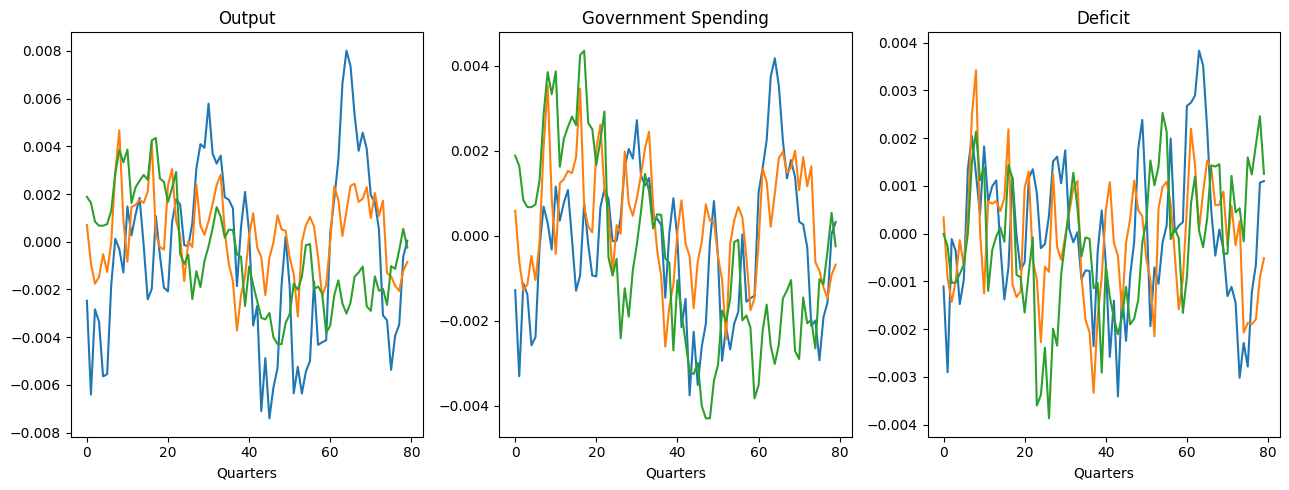

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))
axes[0].plot(data_simul_ha["Y"])
axes[0].plot(data_simul_ta["Y"])
axes[0].plot(data_simul_ra["Y"])
axes[0].set_title("Output")
axes[0].set_xlabel("Quarters")
axes[1].plot(data_simul_ha["G"])
axes[1].plot(data_simul_ta["G"])
axes[1].plot(data_simul_ra["G"])
axes[1].set_title("Government Spending")
axes[1].set_xlabel("Quarters")
axes[2].plot(data_simul_ha["deficit"])
axes[2].plot(data_simul_ta["deficit"])
axes[2].plot(data_simul_ra["deficit"])
axes[2].set_title("Deficit")
axes[2].set_xlabel("Quarters")
fig.tight_layout()